1. Load and explore the dataset.

In [1]:
import pandas as pd
df=pd.read_csv('/content/stock_data.csv')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 972 entries, 0 to 971
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       972 non-null    object 
 1   Ticker     972 non-null    object 
 2   Adj Close  972 non-null    float64
 3   Close      972 non-null    float64
 4   High       972 non-null    float64
 5   Low        972 non-null    float64
 6   Open       972 non-null    float64
 7   Volume     972 non-null    float64
dtypes: float64(6), object(2)
memory usage: 60.9+ KB


In [3]:
df.head()

,Date,Ticker,Adj Close,Close,High,Low,Open,Volume
0,2023-07-03,HDFCBANK.NS,1696.631836,1719.800049,1757.500000,1710.000000,1712.500000,22052058.0
1,2023-07-03,INFY.NS,1309.278564,1333.699951,1346.000000,1328.449951,1330.000000,7732412.0
2,2023-07-03,RELIANCE.NS,2405.791992,2414.290283,2420.105225,2358.587158,2361.079346,6077193.0
3,2023-07-03,TCS.NS,3216.993164,3272.300049,3318.800049,3268.750000,3314.300049,1687264.0
4,2023-07-04,HDFCBANK.NS,1704.918579,1728.199951,1747.000000,1713.800049,1723.449951,19397594.0


Dataset contains 972 rows and 8 columns, including stock price information (Adj Close, Close, High, Low, Open, Volume) for multiple tickers over different dates.

In [4]:
#Data Cleaning: Convert the Date column to datetime, handle missing values.
df["Date"] = pd.to_datetime(df["Date"])

In [5]:
# Pivot the dataset to have tickers as columns with 'Adj Close' prices
pivot_df = df.pivot(index="Date", columns="Ticker", values="Adj Close")
pivot_df.head()

Ticker,HDFCBANK.NS,INFY.NS,RELIANCE.NS,TCS.NS
Date,,,,
2023-07-03,1696.631836,1309.278564,2405.791992,3216.993164
2023-07-04,1704.918579,1320.519165,2381.004639,3252.925293
2023-07-05,1650.758179,1322.629761,2377.095703,3263.837646
2023-07-06,1652.435303,1319.291992,2426.992188,3266.737549
2023-07-07,1638.031982,1305.842773,2422.255615,3272.980225


In [6]:
# Check for missing values
pivot_df.isnull().sum()

,0
Ticker,
HDFCBANK.NS,0
INFY.NS,0
RELIANCE.NS,0
TCS.NS,0


Data Preprocessing Completed

In [7]:
#calculate daily returns for PCA analysis
# Calculate daily returns
returns_df = pivot_df.pct_change().dropna()
returns_df.head()

Ticker,HDFCBANK.NS,INFY.NS,RELIANCE.NS,TCS.NS
Date,,,,
2023-07-04,0.004884,0.008585,-0.010303,0.011169
2023-07-05,-0.031767,0.001598,-0.001642,0.003355
2023-07-06,0.001016,-0.002524,0.020991,0.000888
2023-07-07,-0.008716,-0.010194,-0.001952,0.001911
2023-07-10,-0.002379,-0.000789,0.038521,-0.017211


Daily Returns Computed

Returns were calculated as the percentage change in adjusted close prices.

This dataset will be used for PCA to identify patterns in stock movements.

In [8]:
#standardize the returns data to ensure all features contribute equally to PCA. ​
from sklearn.preprocessing import StandardScaler

# Standardize the returns data
scaler = StandardScaler()
scaled_returns = scaler.fit_transform(returns_df)
scaled_returns_df = pd.DataFrame(scaled_returns, index=returns_df.index, columns=returns_df.columns)
scaled_returns_df.head()

Ticker,HDFCBANK.NS,INFY.NS,RELIANCE.NS,TCS.NS
Date,,,,
2023-07-04,0.371336,0.529898,-0.850945,0.831701
2023-07-05,-2.446450,0.051360,-0.209095,0.200246
2023-07-06,0.073941,-0.230946,1.468043,0.000978
2023-07-07,-0.674293,-0.756306,-0.232061,0.083597
2023-07-10,-0.187066,-0.112169,2.767147,-1.461503


Standardization Completed

The dataset is now scaled with a mean of 0 and a standard deviation of 1.

Standardization ensures that PCA treats all stocks equally.

In [9]:
#apply PCA to identify the most significant components.
from sklearn.decomposition import PCA
import numpy as np

pca = PCA()
principal_components = pca.fit_transform(scaled_returns)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

pca_df = pd.DataFrame(principal_components, index=scaled_returns_df.index)

explained_variance, cumulative_variance

(array([0.46971781, 0.3022731 , 0.15700178, 0.07100731]),
 array([0.46971781, 0.77199091, 0.92899269, 1.        ]))

PCA Results

First Principal Component explains 47% of the variance.

First Two Components explain 77% of the variance.

First Three Components explain 93% of the variance.

In [10]:
#To capture at least 95% of the variance, use the first three principal components. Next, optimize the portfolio using this reduced data

# Select the number of principal components to retain (95% variance)
num_components = np.where(cumulative_variance >= 0.95)[0][0] + 1

# Reduce the dataset to selected principal components
pca_reduced = PCA(n_components=num_components)
reduced_data = pca_reduced.fit_transform(scaled_returns)

reduced_data_df = pd.DataFrame(reduced_data, index=scaled_returns_df.index)

reduced_data_df.head(), num_components

(                   0         1         2         3
 Date                                              
 2023-07-04  0.646178 -0.767271 -0.891923 -0.180938
 2023-07-05 -0.755762 -1.753032  1.557814  0.022152
 2023-07-06  0.415785  0.992296  1.001023 -0.233190
 2023-07-07 -0.738365 -0.361042  0.319312 -0.556790
 2023-07-10  0.000150  2.145892  2.133928  0.825935,
 np.int64(4))

Dimensionality Reduction Completed

Selected 4 principal components to retain 95% of the variance.

The dataset is now transformed into a lower-dimensional space.

In [11]:
import cvxpy as cp

# Define the number of assets (tickers)
num_assets = len(returns_df.columns)

# Define optimization variables
weights = cp.Variable(num_assets)
expected_returns = returns_df.mean().values

# Construct the covariance matrix from reduced data
covariance_matrix = np.cov(reduced_data_df.T)

# Define the objective function (minimize portfolio variance)
portfolio_variance = cp.quad_form(weights, covariance_matrix)
objective = cp.Minimize(portfolio_variance)

# Constraints: weights sum to 1 and are non-negative
constraints = [cp.sum(weights) == 1, weights >= 0]

# Solve the optimization problem
problem = cp.Problem(objective, constraints)
problem.solve()

# Get optimal weights
optimal_weights = weights.value
optimal_weights_df = pd.DataFrame(optimal_weights, index=returns_df.columns, columns=["Optimal Weight"])
optimal_weights_df

,Optimal Weight
Ticker,
HDFCBANK.NS,0.082231
INFY.NS,0.127784
RELIANCE.NS,0.246020
TCS.NS,0.543965


Portfolio Optimization Completed

Optimal Weights:

HDFCBANK.NS: 8.2%

INFY.NS: 12.8%

RELIANCE.NS: 24.6%

TCS.NS: 54.4%

The optimized portfolio minimizes risk based on PCA-transformed data.

These percentages represent how much of your total capital should be allocated to each stock to minimize risk based on PCA and convex optimization.

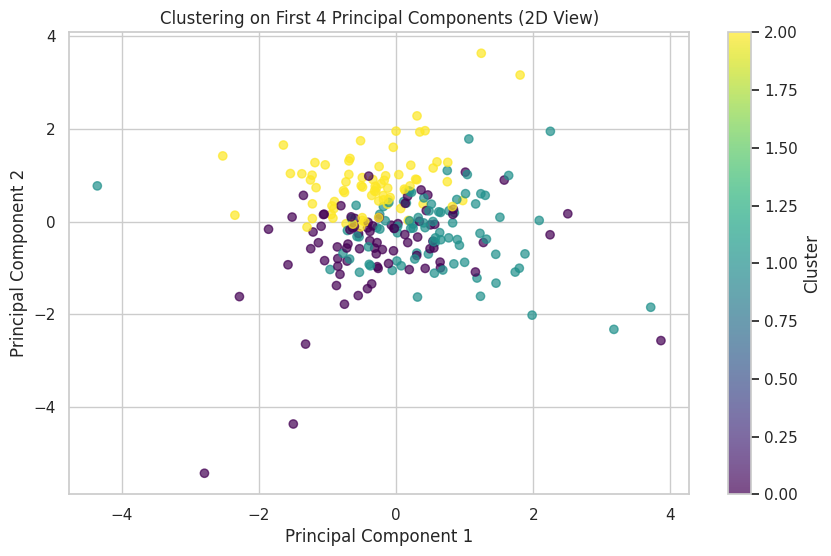

In [18]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Step 1: Select first 4 principal components
pca_4 = principal_components[:, :4]  # Already computed using PCA earlier

# Step 2: Scale the data (optional but improves clustering results)
scaler = StandardScaler()
pca_4_scaled = scaler.fit_transform(pca_4)

# Step 3: Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(pca_4_scaled)

# Step 4: Visualize the clusters in 2D (using first 2 components)
plt.figure(figsize=(10,6))
plt.scatter(pca_4_scaled[:, 0], pca_4_scaled[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.title('Clustering on First 4 Principal Components (2D View)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.colorbar(label='Cluster')
plt.show()


In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Define labels: Up (1) if next day's return is positive, Down (0) otherwise
y = (returns_df.shift(-1).mean(axis=1) > 0).astype(int)

# Use the first 4 principal components as features
X = principal_components[:, :4]

# Remove last row to align with labels
X, y = X[:-1], y[:-1]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Accuracy and Confusion Matrix
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.5918367346938775
Confusion Matrix:
 [[ 8 13]
 [ 7 21]]


In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],       # Type of regularization
    'solver': ['liblinear']         # Solver supporting L1 and L2
}

# Initialize Logistic Regression model
log_reg = LogisticRegression()

# Grid Search with Cross-Validation
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model after tuning
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Best Parameters:", grid_search.best_params_)
print("Optimized Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)


Best Parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Optimized Accuracy: 0.5918367346938775
Confusion Matrix:
 [[ 8 13]
 [ 7 21]]


In [30]:
# Train Logistic Regression model with best hyperparameters
best_log_reg = LogisticRegression(C=10, penalty='l1', solver='liblinear')
best_log_reg.fit(X_train, y_train)

# Make predictions
y_pred = best_log_reg.predict(X_test)

# Evaluate accuracy and confusion matrix
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Optimized Logistic Regression Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)

Optimized Logistic Regression Accuracy: 0.5918367346938775
Confusion Matrix:
 [[ 8 13]
 [ 7 21]]


In [39]:
# Try different classification models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

models = {

    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Support Vector Machine": SVC(probability=True, random_state=42) # probability=True for ROC AUC
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

    print(f"{name} Accuracy: {accuracy}")

# Feature Importance (if applicable)
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    for i, importance in enumerate(importances):
        print(f"Feature {i+1} Importance: {importance}")

# Evaluate using more metrics (Precision, Recall, F1-score, ROC AUC)
from sklearn.metrics import classification_report, roc_auc_score

for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\n{name} Classification Report:\n{classification_report(y_test, y_pred)}")
    if hasattr(model, 'predict_proba'): # Check if the model supports probability estimates
        y_prob = model.predict_proba(X_test)[:, 1] # Probabilities for the positive class
        roc_auc = roc_auc_score(y_test, y_prob)
        print(f"{name} ROC AUC: {roc_auc}")

Random Forest Accuracy: 0.6122448979591837
Gradient Boosting Accuracy: 0.7346938775510204
Support Vector Machine Accuracy: 0.5714285714285714

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.52      0.54        21
           1       0.66      0.68      0.67        28

    accuracy                           0.61        49
   macro avg       0.60      0.60      0.60        49
weighted avg       0.61      0.61      0.61        49

Random Forest ROC AUC: 0.6632653061224489

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.76      0.71        21
           1       0.80      0.71      0.75        28

    accuracy                           0.73        49
   macro avg       0.73      0.74      0.73        49
weighted avg       0.74      0.73      0.74        49

Gradient Boosting ROC AUC: 0.7653061224489797

Support Vector Machine Classificati

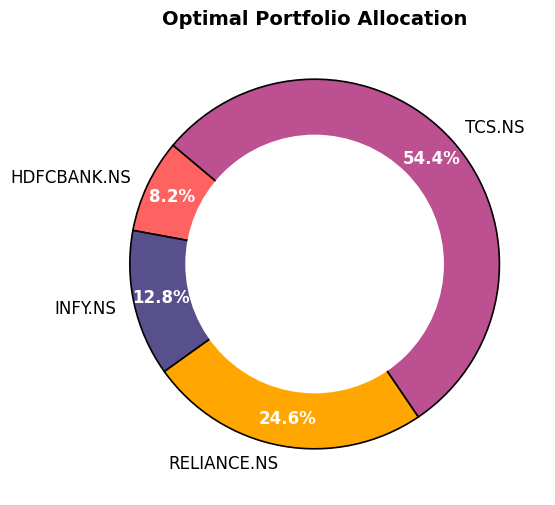

In [13]:
import matplotlib.pyplot as plt

# Define data
tickers = ["HDFCBANK.NS", "INFY.NS", "RELIANCE.NS", "TCS.NS"]
weights = [8.2, 12.8, 24.6, 54.4]
colors = ["#ff6361", "#58508d", "#ffa600", "#bc5090"]

# Create a styled pie chart
plt.figure(figsize=(8, 6))
wedges, texts, autotexts = plt.pie(
    weights, labels=tickers, autopct='%1.1f%%', colors=colors, startangle=140,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.2},
    textprops={'fontsize': 12}, pctdistance=0.85
)

# Enhance the visual appeal
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# Draw a circle at the center to create a donut chart
centre_circle = plt.Circle((0,0), 0.70, fc='white')
plt.gca().add_artist(centre_circle)

plt.title("Optimal Portfolio Allocation", fontsize=14, fontweight="bold")
plt.show()

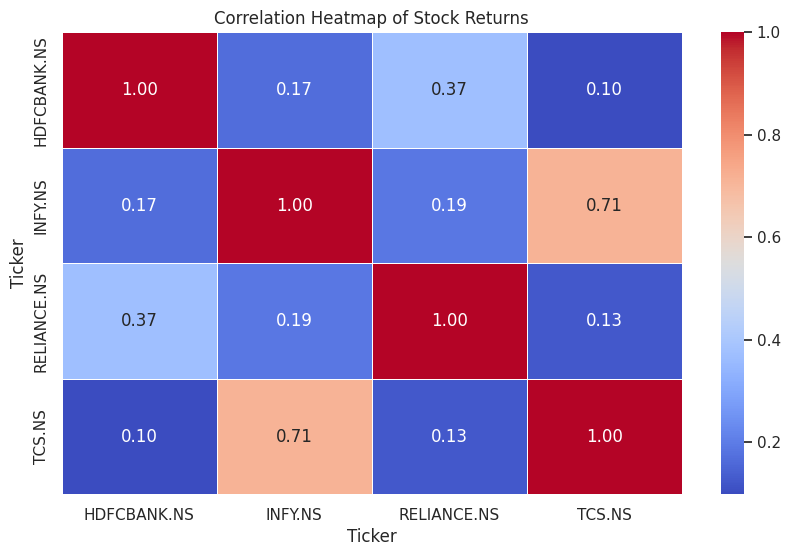

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
sns.set(style="whitegrid")
# Correlation heatmap of stock returns
plt.figure(figsize=(10, 6))
sns.heatmap(returns_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Stock Returns")
plt.show()

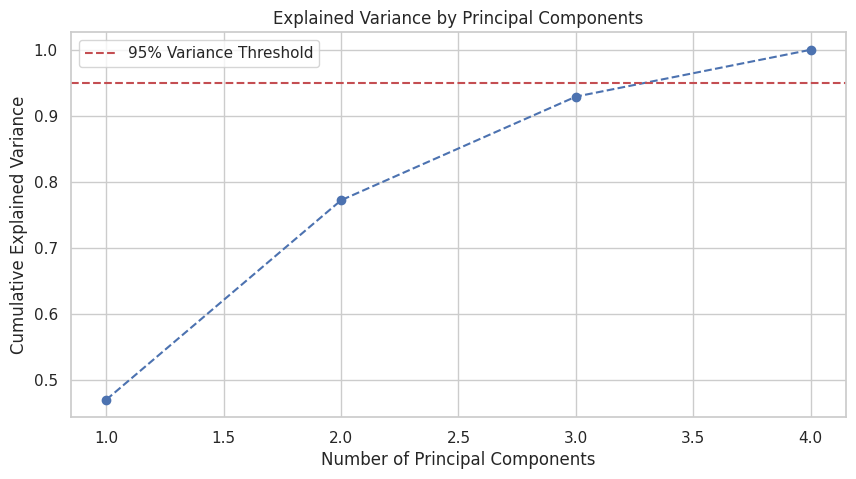

In [15]:
# Explained variance plot for PCA
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker="o", linestyle="--")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by Principal Components")
plt.axhline(y=0.95, color="r", linestyle="--", label="95% Variance Threshold")
plt.legend()
plt.show()

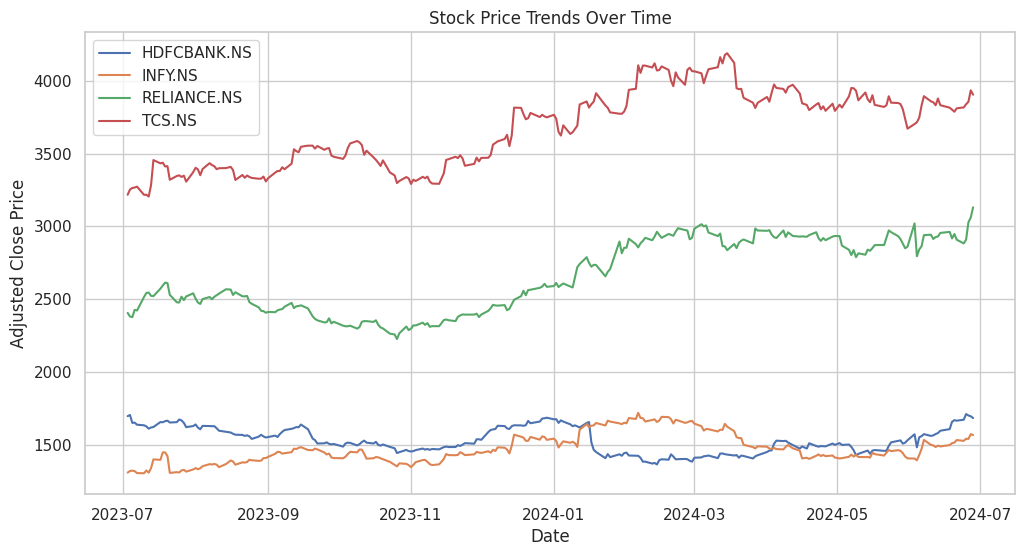

In [16]:
# Plot historical stock prices
plt.figure(figsize=(12, 6))
for ticker in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[ticker], label=ticker)
plt.legend()
plt.title("Stock Price Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.show()